In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os, re
import seaborn as sns

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### For each dataset folder, load each one, get the total timespan of the CSV file, calculate gaps > 10 min, then calculate fraction of gaps over total duration.

In [31]:
def calculate_gaps_in_glucose_data(folder_path):
    # Compile the pattern to match the filenames you want to process
    pattern = re.compile(r'(train|test)_[a-f0-9]+.csv')
    
    # Find all CSV files in the folder that match the pattern
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    # List to store the results
    results = []
    
    # Loop through each CSV file that matches the pattern
    for file in csv_files:
        filename = os.path.basename(file)
        
        # Match the file against the pattern to ensure it's a valid dataset file
        if pattern.match(filename):
            #print(f"Processing file: {filename}")
            
            # Read the CSV file into a dataframe
            data = pd.read_csv(file, low_memory=False)

            # Strip any whitespace from the 'type' column and convert to lowercase
            data['type'] = data['type'].str.strip().str.lower()

            # Filter only rows where "type" is "cbg"
            cbg_data = data[data['type'] == 'cbg']

            # Ensure the data is sorted by time
            cbg_data = cbg_data.sort_values(by='time').reset_index(drop=True)

            # If there is no data or only one row, skip this file
            if cbg_data.shape[0] < 2:
                print(f"Skipping {filename}: not enough 'cbg' data points.")
                continue

            # Convert the 'time' column to datetime objects using a flexible format
            cbg_data['time'] = pd.to_datetime(cbg_data['time'], errors='coerce', utc=True)

            # Drop rows with non-convertible 'time' values (if any)
            cbg_data = cbg_data.dropna(subset=['time'])

            # Check if cbg_data is empty after dropna
            if cbg_data.empty:
                #print(f"Skipping {filename}: All 'time' values are NaT or invalid after conversion.")
                continue

            # Calculate total time elapsed (from the first to the last timestamp)
            total_time_elapsed = (cbg_data['time'].iloc[-1] - cbg_data['time'].iloc[0]).total_seconds() / 60  # in minutes
            
            # Calculate the differences between consecutive timestamps
            time_diffs = cbg_data['time'].diff().dt.total_seconds().div(60).fillna(0)  # in minutes
            
            # Identify gaps (where the difference is more than 5 minutes)
            gaps = time_diffs[time_diffs > 5]
            
            # Calculate total gap time
            total_gap_time = gaps.sum()
            
            # Calculate the fraction of time that is gaps
            gap_fraction = total_gap_time / total_time_elapsed if total_time_elapsed > 0 else 0
            
            # Store the results for this file
            results.append({
                'file': filename,
                'total_time_elapsed (min)': total_time_elapsed,
                'total_gap_time (min)': total_gap_time,
                'gap_fraction': gap_fraction
            })
    
    # Create a dataframe to display the results as a table
    results_df = pd.DataFrame(results)
        
    # Print the results in a table format
    from IPython.display import display, HTML
    display(HTML("<style>.dataframe { width:100% !important; }</style>"))
    # Display the DataFrame
    #display(results_df)   # Uncomment if you want to see the raw numbers

    # Plot a histogram of gap_fraction
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['gap_fraction'], bins=100, kde=False)
    plt.title('Histogram of Gap Fraction Across Datasets')
    plt.xlabel('Gap Fraction')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

,file,total_time_elapsed (min),total_gap_time (min),gap_fraction
0,train_ae180ee202e037d5adfa56686cede4b03c4eaa74...,249116.683333,6728.916667,0.027011
1,train_a677c3887f57acfa6272a023c3d574bfeb3d3c59...,152633.150000,5335.166667,0.034954
2,train_fc0c53e52c53c8de2cf546e5e82008ec8e9f375a...,136792.450000,6043.483333,0.044180
3,train_db24ba0dee0434c704265a2fe8e2d2477e82754b...,161275.683333,4719.933333,0.029266
4,train_5348386e6c0ae79e0617741339cec5b48cb72b1b...,154076.383333,3072.633333,0.019942
...,...,...,...,...
145,train_e4f20f2ea17ddd855c19c567972e601b5a5ecca9...,207280.504467,7473.327383,0.036054
146,train_c6c5c87bfc5aa0402d81eedd07b9da19e68fdf63...,154071.600000,2880.833333,0.018698
147,train_d30c6901fe118ff366a7876d6fb77c41b0698214...,279351.133333,15650.588933,0.056025
148,train_bb1f3c665619821a88ac0a85d5daf5a7f02b7729...,178551.354633,10030.029183,0.056174


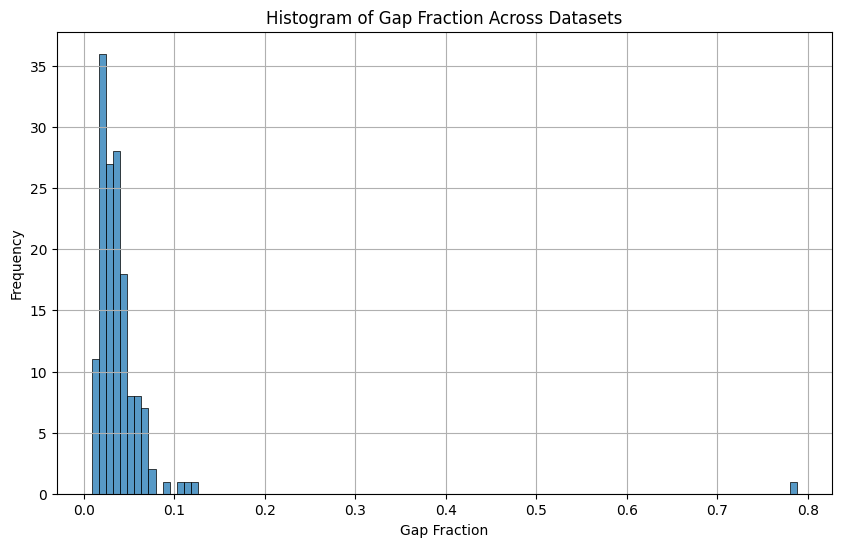

In [14]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-HCL150-train/train-data'
calculate_gaps_in_glucose_data(folder_path)

,file,total_time_elapsed (min),total_gap_time (min),gap_fraction
0,test_88217d002651eb995e96432929c45ff534535a6fe...,43193.935850,1363.810750,0.031574
1,test_ad5e634276063cc617a900e7f90fbbbe7d16aaf5b...,42963.784467,2070.050200,0.048181
2,test_f08a48c862845ddacaf8e654f8fcb3c278b28aa2a...,43018.009067,1388.950000,0.032288
3,test_d7612a1284333ed1f5dcaad85f88944014a96c912...,43163.709950,875.476467,0.020283
4,test_342d5a9fd233bcb771ca0290418398ddd4b0a1995...,43189.088417,1244.772533,0.028821
...,...,...,...,...
145,test_e22a953c3fbc69f85c7011274d298d4adcde0375d...,43194.387467,2440.248017,0.056495
146,test_c7a9dad87e38f1cdc5dc1082cf67eaae9c37960dc...,43194.266667,720.050000,0.016670
147,test_c021cdbd30079e39b0527dbf337dc333581253bc1...,43197.533333,1117.383333,0.025867
148,test_1535833a348f9d266ff5976edac32830b7d9a4c01...,43195.404533,596.249617,0.013804


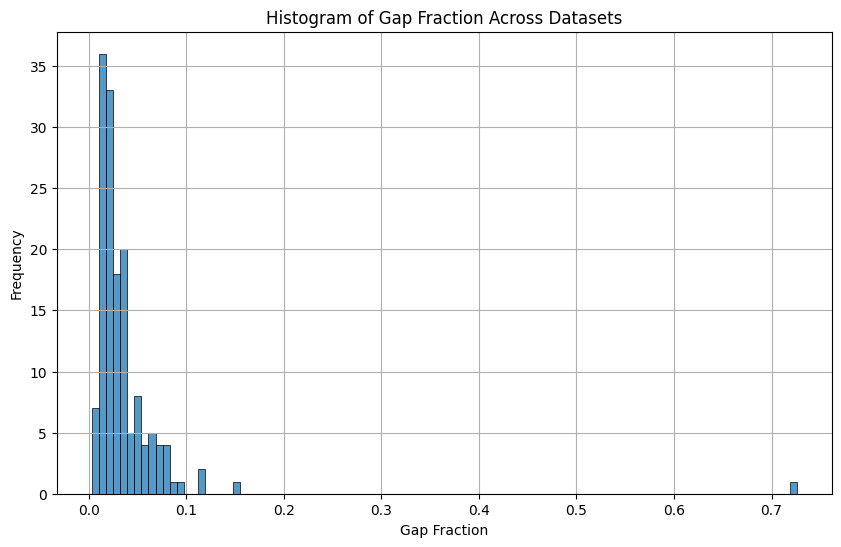

In [17]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-HCL150-test/test-data'
calculate_gaps_in_glucose_data(folder_path)

,file,total_time_elapsed (min),total_gap_time (min),gap_fraction
0,train_dcbd4262686431f9dc5a8663f241648a6620e2eb...,1.310393e+05,45947.533333,0.350639
1,train_feb3331652f61937456a430cfebc93eb36d27e9f...,2.635062e+05,184026.833333,0.698378
2,train_63c655258c1239cfae20ab8296c46bd8c9228dd3...,2.030357e+05,38180.550000,0.188048
3,train_29cb62197ee2f653a2a78eeffadfe48c3660f7ba...,1.526365e+05,65624.573500,0.429940
4,train_7ec677af9a722e5b48e647c557c15b6cac6d3e2c...,5.456169e+05,526639.050000,0.965218
5,train_c4ad056b0dc05200a2c64c4085239a209b20e95a...,1.295979e+05,25400.316667,0.195993
6,train_1d7f529d94cc119a9692ac69d0ee2aaf1cecf01d...,1.123120e+05,21415.633333,0.190680
7,train_fd4fa80bb54c5871728ca06840ab35b4ebaca253...,5.671283e+05,374727.050000,0.660745
8,train_dd63373c1fe469e39db833bd9c38fabb5c72a3f3...,1.943947e+05,37460.800000,0.192705
9,train_f1757ff94aefbb02674a39e95a2407578ab9e79c...,6.004706e+05,118268.573933,0.196960


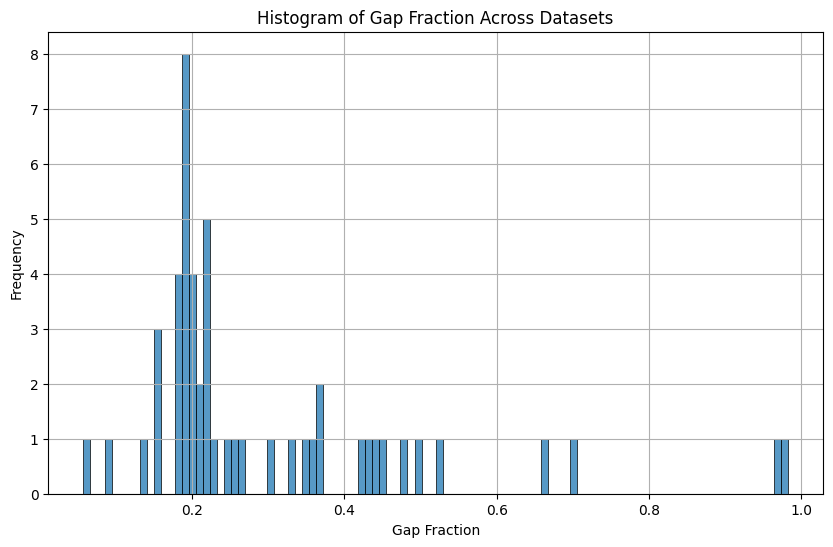

In [25]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-PA50-train/train-data'
calculate_gaps_in_glucose_data(folder_path)

,file,total_time_elapsed (min),total_gap_time (min),gap_fraction
0,train_416c497cc0567b7f3c4401611a76f1d5cd859efa...,5.975927e+05,142213.883333,0.237978
1,train_36456004b763622d7646bf0f42e77a1189ec044d...,5.302302e+05,417097.583333,0.786635
2,train_b251f16178ce26240640826fae64062c1ec3c516...,7.070362e+05,160823.050000,0.227461
3,train_6deb1b5679a43ca785749154d93d17de6ccdf929...,1.038236e+06,201485.533333,0.194065
4,train_9036ac5808b094bc027a31a39e9e8514dad2ad43...,1.411192e+06,418265.900000,0.296392
...,...,...,...,...
95,train_ee6ffcc30cdeed81b998b84b770d8d4ab7681a13...,4.406337e+05,19939.066667,0.045251
96,train_aa7d0e72dd55982f0a007c707fb3772125ad88bc...,5.515167e+05,48291.766667,0.087562
97,train_2e63dee36bbe685c07b4018b2557d047004ecba7...,7.027164e+05,186603.916667,0.265547
98,train_55c5eac723fb563a3f67906b98fe8a90485afd88...,4.857482e+05,109017.683333,0.224433


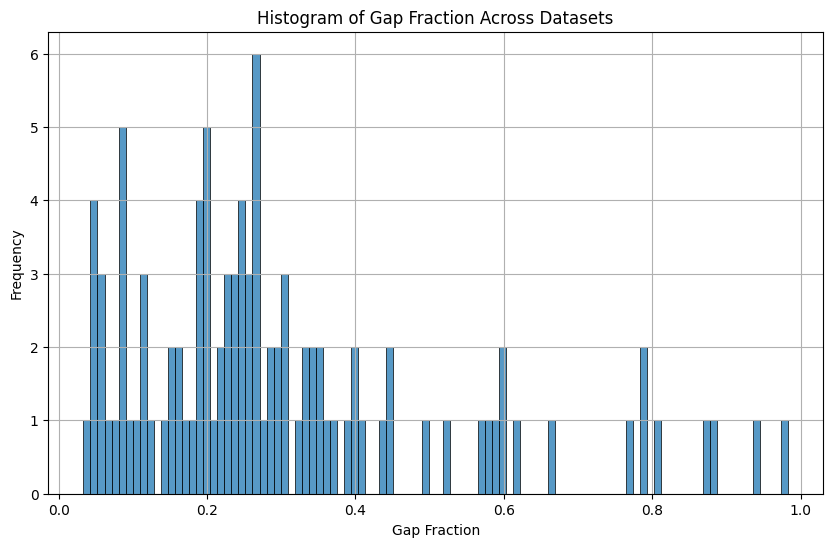

In [32]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-SAP100-train/train-data'
calculate_gaps_in_glucose_data(folder_path)

,file,total_time_elapsed (min),total_gap_time (min),gap_fraction
0,test_2eff7c6e22b3159f47ec8846cbedc02cd25217e5a...,129592.183333,7748.300000,0.059790
1,test_55659c31e89c3c27ee3926d946af025a1c273033f...,165593.750000,63023.850000,0.380593
2,test_b09b5120b5a7049bf7ca0c9fa89b9a04ddf831674...,129595.500000,23174.800000,0.178824
3,test_301e2b3f992a2ee94fcbd13a207de095e06a99c68...,129594.966667,24705.350000,0.190635
4,test_d4727451ea7021dbfa6fd9d62fa57afccaa0d4e1b...,129594.050000,55677.050000,0.429627
...,...,...,...,...
95,test_2e10168b4b0e1968ec2d3b5775699c5111ecba855...,129354.650000,21327.983333,0.164880
96,test_07f024f9b2df04a3556a231aca535df04709564d2...,129595.433333,13889.550000,0.107176
97,test_777eb0f5a6877c8058352063e1e22400f10bed58e...,129596.283333,35523.300000,0.274107
98,test_994546ec227675c3ea9a477ce6c90900a60f88a32...,129266.150000,58614.166667,0.453438


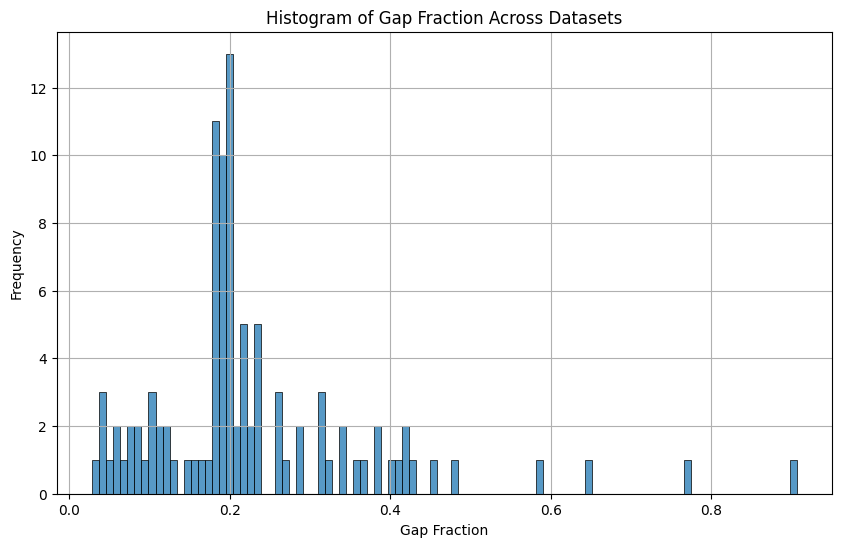

In [33]:
# Example usage: use your provided folder path
folder_path = 'Tidepool_Datasets/Tidepool-JDRF-SAP100-test/test-data'
calculate_gaps_in_glucose_data(folder_path)